<a href="https://colab.research.google.com/github/cgarcia98/Astronomy-and-Astrophysics-Template/blob/main/Copia_de_gaia_galactic_orbits_notext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computing Galactic Orbits of Stars with Gala

## Authors
Adrian Price-Whelan, Stephanie T. Douglas

## Companion Content
Astropy Docs: [Description of the Galactocentric frame in astropy coordinates](
http://docs.astropy.org/en/latest/generated/examples/coordinates/plot_galactocentric-frame.html#sphx-glr-generated-examples-coordinates-plot-galactocentric-frame-py)

In [1]:
!pip install gala astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.7 MB/s eta 0:00:00


In [2]:
!pip install gala

## Imports

In [4]:
# astropy imports
import astropy.coordinates as coord
from astropy.table import QTable
import astropy.units as u
from astroquery.gaia import Gaia

# Third-party imports
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
%matplotlib inline

# gala imports
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

# Google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# First dataset: Hyades
query_text = '''SELECT dr3.ra, dr3.dec, dr3.parallax, dr3.pmra, dr3.pmdec, dr3.radial_velocity,
dr3.phot_g_mean_mag, dr3.phot_bp_mean_mag, dr3.phot_rp_mean_mag, dr3.ruwe, dr3.phot_bp_mean_flux_over_error,
dr3.phot_rp_mean_flux_over_error, dr3.parallax_over_error, dr3.ra_error, dr3.dec_error, dr3.pmra_error,
dr3.pmdec_error, dr3.radial_velocity_error
FROM gaiadr3.gaia_source AS dr3
WHERE 1 = CONTAINS(
          POINT('ICRS', dr3.ra, dr3.dec),
          CIRCLE('ICRS', 66.75, 15.87, 2.5)
      )
      AND dr3.parallax BETWEEN 18 AND 24
      AND dr3.parallax_over_error > 10
      AND dr3.radial_velocity IS NOT null
ORDER BY random_index
'''

In [6]:

# Note: the following lines require an internet connection, so we have
# provided the results of this query as a FITS file included with the
# tutorials repository. If you have an internet connection, feel free
# to uncomment these lines to retrieve the data with `astroquery`:
job = Gaia.launch_job(query_text)
gaia_data = job.get_results()
#gaia_data.write('/content/drive/MyDrive/gaia_data3.fits', overwrite=True)
print(len(gaia_data))

85


In [7]:
#gaia_data = QTable.read('/content/drive/MyDrive/Galactica/gaia_data.fits')

In [8]:
gaia_data[:4]

ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ruwe,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,parallax_over_error,ra_error,dec_error,pmra_error,pmdec_error,radial_velocity_error
deg,deg,mas,mas / yr,mas / yr,km / s,mag,mag,mag,,,,,mas,mas,mas / yr,mas / yr,km / s
float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
64.83451345915711,14.316347980068391,20.850920231259277,107.93602845660209,-17.7577790655432,38.881653,11.98053,13.047244,10.954753,1.1053181,1303.7185,2084.5994,1242.1691,0.014768766,0.010628361,0.01971493,0.016130466,0.50691956
67.51380640413643,14.903572814981922,21.091518884547874,-18.6839859974469,-36.3746533095047,-21.631842,11.689961,12.617517,10.73402,1.2792013,1829.9717,2651.5122,993.8325,0.019467084,0.009524179,0.025904147,0.01578284,0.4179491
66.11855100326646,16.886053964801455,21.781982400489085,112.37591155236862,-25.540146749299083,37.58888,7.6696334,7.962704,7.1908584,0.9669478,1001.3198,779.2743,624.3912,0.03165041,0.016057318,0.03977904,0.030610695,0.13147263
67.93658293586253,15.630149907181586,21.928109289904448,104.99937028732845,-31.718638053931382,40.46022,13.436778,14.924236,12.22202,1.2680652,183.91415,485.15646,1031.8352,0.018931303,0.00984147,0.023308018,0.015581603,1.5415019


In [9]:
dist = coord.Distance(parallax=u.Quantity(gaia_data['parallax']))
dist_err = (gaia_data['parallax_over_error'] / gaia_data['parallax']**2) * dist.unit
dist.min(), dist.max(), dist_err.mean()

(<Distance 42.3376298 pc>, <Distance 55.2141736 pc>, <Quantity 1.58549711 pc>)

It looks like the closest star in our sample is about 42 pc away, and the farthest is almost 55 pc, as we expected.

In [10]:
c = coord.SkyCoord(ra=gaia_data['ra'],
                   dec=gaia_data['dec'],
                   distance=dist,
                   pm_ra_cosdec=gaia_data['pmra'],
                   pm_dec=gaia_data['pmdec'],
                   radial_velocity=gaia_data['radial_velocity'])

c_err = coord.SkyCoord(ra=gaia_data['ra_error'],
                         dec=gaia_data['dec_error'],
                         distance=dist_err,
                         pm_ra_cosdec=gaia_data['pmra_error'],
                         pm_dec=gaia_data['pmdec_error'],
                         radial_velocity=gaia_data['radial_velocity_error'])


In [11]:
N = len(c)   # número de estrellas
S = 128      # número de muestras Monte Carlo

rng = np.random.default_rng(42)

# ----------------------------------------------------------
# Función genérica: genera S muestras MC para un parámetro
# ----------------------------------------------------------
def mc_sample(values, errors, unit, n_samples=S):
    """
    values, errors : arrays (N,) sin unidades (usar .value)
    unit           : astropy unit, p.ej. u.pc, u.mas/u.yr
    n_samples      : int
    Output         : Quantity (N, S)
    """
    return rng.normal(
        loc   = values[:, None],
        scale = errors[:, None],
        size  = (len(values), n_samples)
    ) * unit


# -------------------------
# Distancia
# -------------------------
dist_s = mc_sample(c.distance.to(u.pc).value,
                 c_err.distance.to(u.pc).value,
                 u.pc)

# -------------------------
# Movimientos propios
# -------------------------
pm_ra_s  = mc_sample(c.pm_ra_cosdec.to(u.mas/u.yr).value,
                   c_err.pm_ra_cosdec.to(u.mas/u.yr).value,
                   u.mas/u.yr)

pm_dec_s = mc_sample(c.pm_dec.to(u.mas/u.yr).value,
                   c_err.pm_dec.to(u.mas/u.yr).value,
                   u.mas/u.yr)

# -------------------------
# Velocidad radial
# -------------------------
rv_s = mc_sample(c.radial_velocity.to(u.km/u.s).value,
               c_err.radial_velocity.to(u.km/u.s).value,
               u.km/u.s)

# -------------------------
# RA y DEC (normalmente sin error, pero aquí permites error)
# -------------------------
ra_s = mc_sample(c.ra.to(u.deg).value,
               c_err.ra.to(u.deg).value,
               u.deg)

dec_s = mc_sample(c.dec.to(u.deg).value,
                c_err.dec.to(u.deg).value,
                u.deg)

In [12]:
c_samples = coord.SkyCoord(
    ra=ra_s,
    dec=dec_s,
    distance=dist_s,
    pm_ra_cosdec=pm_ra_s,
    pm_dec=pm_dec_s,
    radial_velocity=rv_s,
)

Note: as described in the [Gaia DR2 data model](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html), the Gaia column `pmra` contains the cos(dec) term. In Astropy coordinates, the name of this component is `pm_ra_cosdec`.

We'll use a distance of 8.1 kpc — more consistent with the [recent results from the GRAVITY collaboration](https://arxiv.org/abs/1807.09409) than the deafult value — and a solar height of 0 pc. We'll use the default solar velocity. We can transform our data to this frame using the `transform_to()` method by specifying the `Galactocentric` frame with our adopted values:

In [13]:
galcen = c.transform_to(coord.Galactocentric(z_sun=0*u.pc,
                                             galcen_distance=8.1*u.kpc))

galcen_samples = c_samples.transform_to(coord.Galactocentric(z_sun=0*u.pc,
                                             galcen_distance=8.1*u.kpc))


The `galcen` object now contains the data for our sample, but in the Galactocentric frame:

In [14]:
galcen[:10]

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.1 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=0.0 pc, roll=0.0 deg): (x, y, z) in pc
    [(-8143.55845179, -0.08661522, -20.06909952),
     (-8143.83766308, -1.06409498, -18.0295531 ),
     (-8142.51312342,  0.88061271, -17.30726384),
     (-8142.3998639 , -0.77576284, -16.7730454 ),
     (-8143.94812062, -1.49730422, -18.99995151),
     (-8142.98868553, -0.46440046, -18.32335337),
     (-8142.32590114, -1.51454893, -16.81616431),
     (-8143.31435766,  0.25046776, -19.28951129),
     (-8145.42758725, -0.31577644, -17.00494759),
     (-8148.00214986,  1.50792697, -18.52092179)]
 (v_x, v_y, v_z) in km / s
    [(-29.22895076, 226.79947946, 6.38258353),
     ( 36.17222602, 242.34877421, 8.27239277),
     (-28.08092188, 226.56025996, 7.76691837),
     (-29.34940214, 225.37304919, 5.51027804),
     (-29.41243927, 226.39946556, 6.2040621 ),
     (-28.32582889, 226

En este ejemplo, todas las estrellas parecen ser del disco fino con velocidades muy altas en v_y.

We can access the positions of the stars using the `.x`, `.y`, and `.z` attributes, for example:

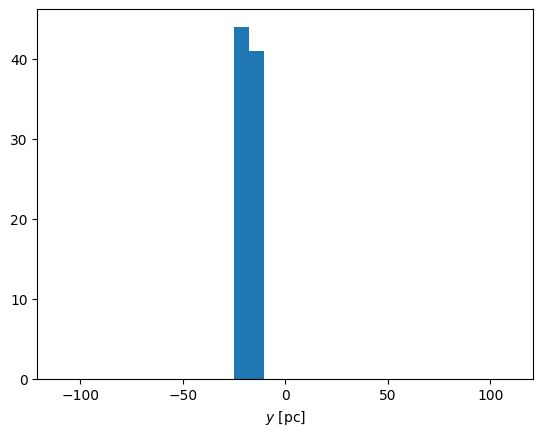

In [15]:
plt.hist(galcen.z.value, bins=np.linspace(-110, 110, 32))
plt.xlabel('$y$ [{0:latex_inline}]'.format(galcen.y.unit));

Similarly, for the velocity components, we can use `.v_x`, `.v_y`, and `.v_z`. For example, to create a classic "UV" plane velocity plot:

Text(0, 0.5, '$v_y$ [$\\mathrm{km\\,s^{-1}}$]')

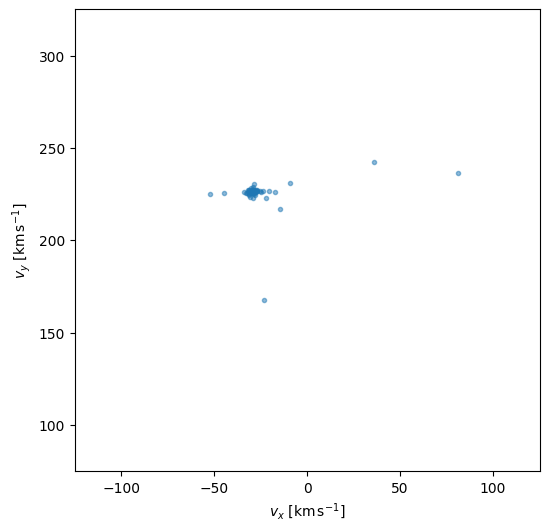

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(galcen.v_x.value, galcen.v_y.value,
        marker='.', linestyle='none', alpha=0.5)

ax.set_xlim(-125, 125)
ax.set_ylim(200-125, 200+125)

ax.set_xlabel('$v_x$ [{0:latex_inline}]'.format(u.km/u.s))
ax.set_ylabel('$v_y$ [{0:latex_inline}]'.format(u.km/u.s))

Along with astrometric and radial velocity data, `Gaia` also provides photometric data for three photometric bandpasses: the broad-band `G`, the blue `BP`, and the red `RP` magnitudes. Let's make a Gaia color-magnitude diagram using the $G_{\rm BP}-G_{\rm RP}$ color and the absolute $G$-band magnitude $M_G$. We'll compute the absolute magnitude using the distances we computed earlier — Astropy `Distance` objects have a convenient `.distmod` attribute that provides the distance modulus:

In [17]:
M_G = gaia_data['phot_g_mean_mag'] - dist.distmod
BP_RP = gaia_data['phot_bp_mean_mag'] - gaia_data['phot_rp_mean_mag']
M_G = M_G*u.mag
BP_RP = BP_RP*u.mag


Text(0, 0.5, '$M_G$')

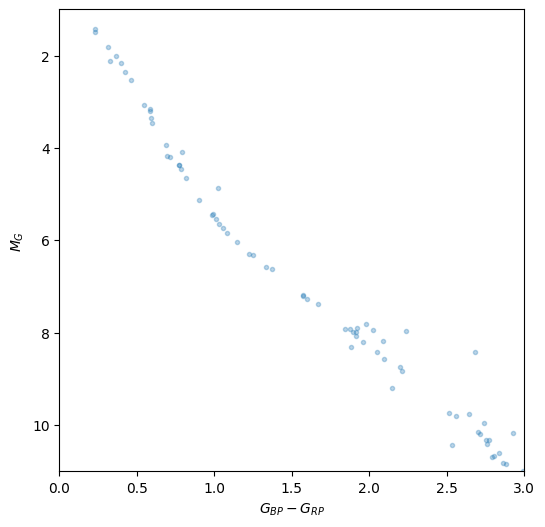

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(BP_RP.value, M_G.value,
        marker='.', linestyle='none', alpha=0.3)

ax.set_xlim(0, 3)
ax.set_ylim(11, 1)

ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')

In [19]:
np.seterr(invalid="ignore")
hi_mass_mask = ((BP_RP > 0.3*u.mag) & (BP_RP < 0.9*u.mag) &
                (M_G > 2*u.mag) & (M_G < 3.5*u.mag) & (np.abs(galcen.v_y - 220*u.km/u.s) < 50*u.km/u.s))

lo_mass_mask = ((BP_RP > 2.0*u.mag) & (BP_RP < 3.0*u.mag) &
                (M_G > 8*u.mag) & (M_G < 10.4*u.mag) & (np.abs(galcen.v_y - 220*u.km/u.s) < 50*u.km/u.s))


Let's also define default colors to use when visualizing the high- and low-mass stars:

In [20]:
hi_mass_color = 'darkblue'
lo_mass_color = 'red'

Let's now visualize these two CMD selections:

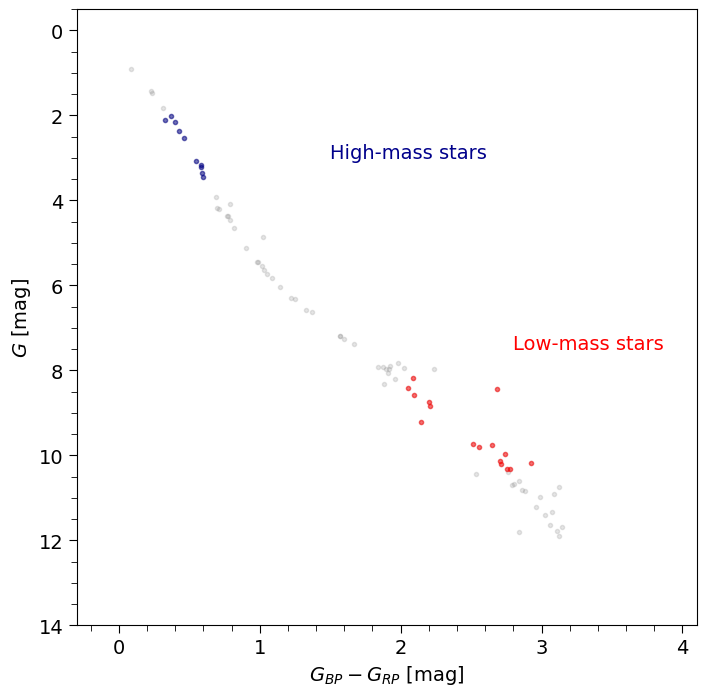

In [21]:
fs = 14
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.plot(BP_RP.value, M_G.value, color='gray',
        marker='.', linestyle='none', alpha=0.2)

for mask, color in zip([lo_mass_mask, hi_mass_mask],
                       [lo_mass_color, hi_mass_color]):
    ax.plot(BP_RP[mask].value, M_G[mask].value,
            marker='.', linestyle='none',
            alpha=0.5, color=color)

ax.set_xlim(-0.3, 4.1)
ax.set_ylim(14, -0.5)

ax.set_xlabel('$G_{BP}-G_{RP}$ [mag]', fontsize=fs)
ax.set_ylabel('$G$ [mag]', fontsize=fs)
ax.tick_params(labelsize=fs, size=6)
ax.minorticks_on()
ax.tick_params(which='minor', size=4)
ax.text(1.5, 3., 'High-mass stars', color=hi_mass_color, fontsize=fs)
ax.text(2.8, 7.5, 'Low-mass stars', color=lo_mass_color, fontsize=fs)
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))

plt.savefig('CMD.pdf', dpi=300, bbox_inches='tight')

Thus far, we've used the color-magnitude diagram (using parallaxes and photometry from Gaia to compute absolute magnitudes) to select samples of high- and low-mass stars based on their colors.

In what follows, we'll compute Galactic orbits for stars in the high- and low-mass star selections above and compare.

## Using `gala` to numerically integrate Galactic stellar orbits

`gala` is an Astropy affiliated package for Galactic dynamics. `gala` provides functionality for representing analytic mass models that are commonly used in Galactic dynamics contexts for numerically integrating stellar orbits. For examples, see Chapter 3 of Binney and Tremaine (2008). The gravitational potential models are defined by specifying parameters like mass, scale radii, or shape parameters and can be combined. Once defined, they can be used in combination with numerical integrators provided in `gala` to compute orbits. `gala` comes with a pre-defined, multi-component, but [simple model for the Milky Way](http://gala.adrian.pw/en/latest/potential/define-milky-way-model.html) that can be used for orbit integrations. Let's create an instance of the `MilkyWayPotential` model and integrate orbits for the high- and low-mass main sequence stars selected above:

In [22]:
milky_way = gp.MilkyWayPotential()
milky_way

<CompositePotential disk,bulge,nucleus,halo>

This model has mass components for the Galactic disk, bulge, nucleus, and halo, and the parameters were defined by fitting measurements of the Milky Way enclosed mass at various radii. See [this document](http://gala.adrian.pw/en/latest/potential/define-milky-way-model.html) for more details. The parameters of the `MilkyWayPotential` can be changed by passing in a dictionary of parameter values to argument names set by the component names. For example, to change the disk mass to make it slightly more massive (the choice `8e10` is arbitrary!):

In [23]:
different_disk_potential = gp.MilkyWayPotential(disk=dict(m=8e10*u.Msun))
different_disk_potential

<CompositePotential disk,bulge,nucleus,halo>

To integrate orbits, we have to combine the mass model with a reference frame into a `Hamiltonian` object. If no reference frame is passed in, it's assumed that we are in a static inertial frame moving with the center of the mass model:

In [24]:
H = gp.Hamiltonian(milky_way)
H2 = gp.Hamiltonian(different_disk_potential)

Now that we have the mass model, we can integrate orbits. Let's now define initial conditions for subsets of the high- and low-mass star selections we did above. Initial conditions in `gala` are specified by creating `PhaseSpacePosition` objects. We can create these objects directly from a `Galactocentric` object, like we have defined above from transforming the Gaia data — we first have to extract the data with a Cartesian representation. We can do this by calling `galcen.cartesian`:

In [25]:
w0_hi = gd.PhaseSpacePosition(galcen[hi_mass_mask].cartesian)
w0_lo = gd.PhaseSpacePosition(galcen[lo_mass_mask].cartesian)
w0 = gd.PhaseSpacePosition(galcen.cartesian)
w0_samples = gd.PhaseSpacePosition(galcen_samples.cartesian)
w0_hi.shape, w0_lo.shape

((10,), (16,))

In [26]:
orbits = H.integrate_orbit(w0, dt=1*u.Myr,
                           t1=0*u.Myr, t2=1500*u.Myr)

orbits_samples = H.integrate_orbit(w0_samples, dt=1*u.Myr,
                                   t1=0*u.Myr, t2=1500*u.Myr)

orbits_hi = H.integrate_orbit(w0_hi, dt=1*u.Myr,
                              t1=0*u.Myr, t2=1500*u.Myr)

orbits_lo = H.integrate_orbit(w0_lo, dt=1*u.Myr,
                              t1=0*u.Myr, t2=1500*u.Myr)

orbits_hi_2 = H2.integrate_orbit(w0_hi, dt=1*u.Myr,
                              t1=0*u.Myr, t2=1500*u.Myr)

orbits_lo_2 = H2.integrate_orbit(w0_lo, dt=1*u.Myr,
                              t1=0*u.Myr, t2=1500*u.Myr)

        Use name instead. [gala.dynamics.core]
        Use name instead.


        Use name instead. [gala.dynamics.orbit]
        Use name instead.


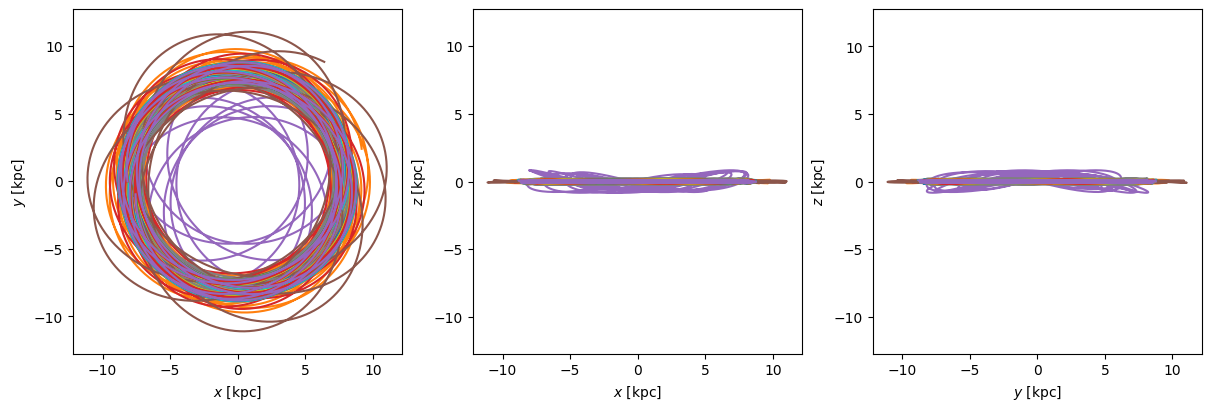

In [27]:
fig = orbits.plot()

In [28]:
peris = orbits_samples.pericenter(approximate=True)

apos = orbits_samples.apocenter(approximate=True)

eccs = orbits_samples.eccentricity(approximate=True)

print(peris.max(), peris.min())
print(apos.max(), apos.min())
print(eccs.max(), eccs.min())

8.039901588546519 kpc 4.309021041001928 kpc
11.20710030757932 kpc 8.144453912777568 kpc
0.3130391390344412 0.012167291402189518


By default this uses a [Leapfrog](https://en.wikipedia.org/wiki/Leapfrog_integration) numerical integration scheme, but the integrator can be customized — see the `gala` [examples](http://gala.adrian.pw/en/latest/examples/integrate-potential-example.html) for more details.

Text(0.5, 0, 'eccentricity')

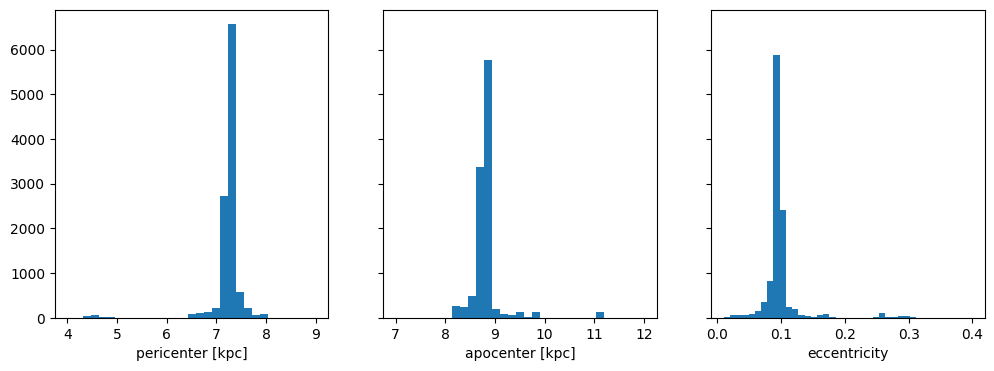

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

axes[0].hist(peris.to_value(u.kpc), bins=np.linspace(4, 9, 32))
axes[0].set_xlabel("pericenter [kpc]")

axes[1].hist(apos.to_value(u.kpc), bins=np.linspace(7, 12, 32))
axes[1].set_xlabel("apocenter [kpc]")

axes[2].hist(eccs.value, bins=np.linspace(0.01, 0.4, 41))
axes[2].set_xlabel("eccentricity")

        Use name instead. [gala.dynamics.core]
        Use name instead.


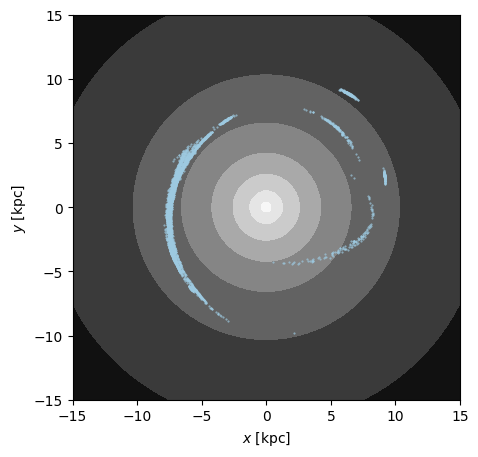

In [ ]:
grid = np.linspace(-15,15,64)
fig,ax = plt.subplots(1, 1, figsize=(5,5))
fig = milky_way.plot_contours(grid=(grid,grid,0), cmap='Greys', ax=ax)
fig = orbits_samples[-1].plot(['x', 'y'], color='#9ecae1', s=1., alpha=0.8,
                      axes=[ax], auto_aspect=False)

In [ ]:
print(orbits_lo.shape)
print(orbits_hi.shape)

(1500, 16)
(1500, 10)


In [ ]:
zmax_hi = orbits_hi.zmax(approximate=True)
zmax_lo = orbits_lo.zmax(approximate=True)
zmax_hi_2 = orbits_hi_2.zmax(approximate=True)
zmax_lo_2 = orbits_lo_2.zmax(approximate=True)

In [ ]:
# Aquí puedo identificar las estrellas de alta y baja masa con la mayor z_max y la menor z_max, y podría hacer lo mismo con la excursión radial, para
# graficar con fundamento los ejemplos. No vale la pena mostrar todos los casos extremos porque los veremos en el histograma, pero puedo ver alguno
# que muestre bien las tendencias de las estrellas.

        Use name instead. [gala.dynamics.orbit]
        Use name instead.


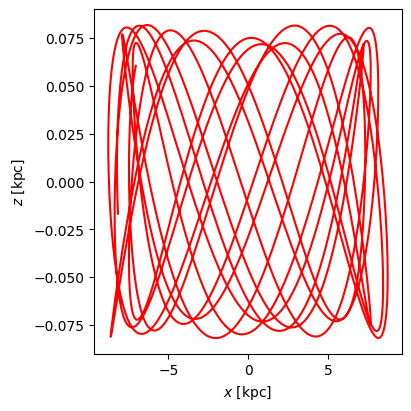

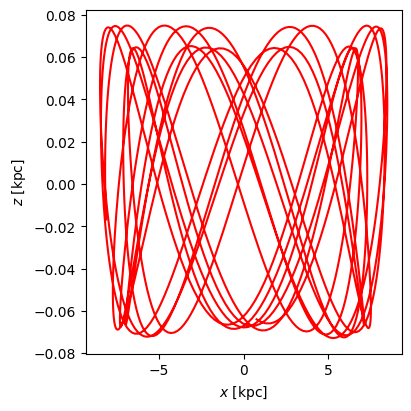

In [ ]:

fig1 = orbits_lo[:, 1].plot(['x', 'z'],
                           auto_aspect=False,
                           color=lo_mass_color)
fig2 = orbits_lo_2[:, 1].plot(['x', 'z'],
                           auto_aspect=False,
                           color=lo_mass_color)

The representation can also be changed, for example, to a cylindrical representation:

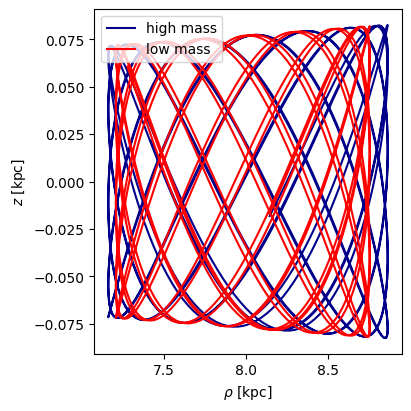

In [ ]:
fig = orbits_hi[:, 2].cylindrical.plot(['rho', 'z'],
                                       color=hi_mass_color,
                                       label='high mass')
_ = orbits_lo[:, 1].cylindrical.plot(['rho', 'z'], color=lo_mass_color,
                                     axes=fig.axes,
                                     label='low mass')

fig.axes[0].legend(loc='upper left')




Let's make histograms of the maximum $z$ heights for these two samples:

In [ ]:
ang_mom_hi = orbits_hi.angular_momentum()
ang_mom_lo = orbits_lo.angular_momentum()
max_hi = ang_mom_hi[2,:,1].max()
max_lo = ang_mom_lo[2,:,1].max()
print(max_hi)
print(ang_mom_hi[1,:,1])


        Use name instead. [gala.dynamics.core]
        Use name instead.


-1.8711246424873382 kpc2 / Myr
[0.04987024 0.0503901  0.05066728 ... 0.03132562 0.02844549 0.02545914] kpc2 / Myr


[-5.         -4.79591837 -4.59183673 -4.3877551  -4.18367347 -3.97959184
 -3.7755102  -3.57142857 -3.36734694 -3.16326531 -2.95918367 -2.75510204
 -2.55102041 -2.34693878 -2.14285714 -1.93877551 -1.73469388 -1.53061224
 -1.32653061 -1.12244898 -0.91836735 -0.71428571 -0.51020408 -0.30612245
 -0.10204082  0.10204082  0.30612245  0.51020408  0.71428571  0.91836735
  1.12244898  1.32653061  1.53061224  1.73469388  1.93877551  2.14285714
  2.34693878  2.55102041  2.75510204  2.95918367  3.16326531  3.36734694
  3.57142857  3.7755102   3.97959184  4.18367347  4.3877551   4.59183673
  4.79591837  5.        ]
[-1.87112464 -1.87112464 -1.87112464 ... -1.87112464 -1.87112464
 -1.87112464]


Text(0.5, 0, '$z_{\\rm max}$ [$\\mathrm{kpc}$]')

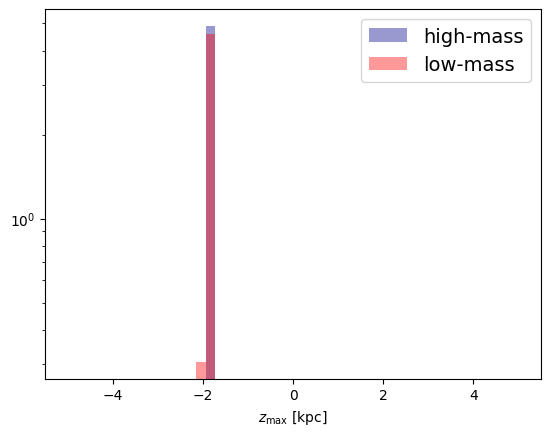

In [ ]:
bins = np.linspace(-5, 5, 50)
print(bins)
print(ang_mom_hi[2,:,1].value)

plt.hist(ang_mom_hi[2,:,:].value.flatten(), bins=bins,
         alpha=0.4, density=True, label='high-mass',
         color=hi_mass_color)
plt.hist(ang_mom_lo[2,:,:].value.flatten(), bins=bins,
         alpha=0.4, density=True, label='low-mass',
         color=lo_mass_color);

plt.legend(loc='best', fontsize=14)

plt.yscale('log')
plt.xlabel(r"$z_{\rm max}$" + " [{0:latex}]".format(zmax_hi.unit))

The distribution of $z$-heights for the low-mass (i.e. typically older) stars is more extended, as we predicted!

In this tutorial, we've used `astroquery` to query the Gaia science archive to retrieve kinematic and photometric data for a small sample of stars with well-measured parallaxes from Gaia DR2. We used the colors and absolute magnitudes of these stars to select subsamples of high- and low-mass stars, which, on average, will provide us with subsamples of stars that are younger and older, respectively. We then constructed a model for the gravitational field of the Milky Way and numerically integrated the orbits of all stars in each of the two subsamples. Finally, we used the orbits to compute the maximum height that each star reaches above the Galactic midplane and showed that the younger (higher-mass) stars tend to have smaller excursions from the Galactic plane, consistent with the idea that stars are either born in a "thinner" disk and dynamically "heated," or that older stars formed with a larger vertical scale-height.

Text(0.5, 0, '$z_{\\rm max}$ [$\\mathrm{kpc}$]')

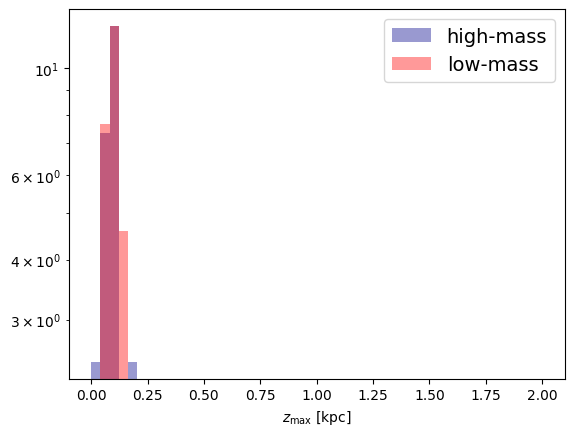

In [ ]:
bins = np.linspace(0, 2, 50)

plt.hist(zmax_hi.value, bins=bins,
         alpha=0.4, density=True, label='high-mass',
         color=hi_mass_color)
plt.hist(zmax_lo.value, bins=bins,
         alpha=0.4, density=True, label='low-mass',
         color=lo_mass_color);

plt.legend(loc='best', fontsize=14)

plt.yscale('log')
plt.xlabel(r"$z_{\rm max}$" + " [{0:latex}]".format(zmax_hi.unit))

## Exercises

1. Choose a stellar system of your interest. It can be a sample of stars with particular properties, a single very peculiar star, stellar clusters, MW satellite galaxies, etc.
2. Compute its/their orbits based on the example above. Take into account that the [Orbit](http://gala.adrian.pw/en/latest/dynamics/orbits-in-detail.html) objects also provide methods for computing apocenter, pericenter distances, eccentricities, and many other features.
3. Take into account possible errors using [this](http://gala.adrian.pw/en/latest/tutorials/Milky-Way-model.html) example.
3. Try changing some properties of the potential (shape, total mass) and describe whether the stellar orbits change and why.


In [ ]:
H = gp.Hamiltonian(different_disk_potential)

orbits_hi = H.integrate_orbit(w0_hi, dt=1*u.Myr,
                              t1=0*u.Myr, t2=1500*u.Myr)

orbits_lo = H.integrate_orbit(w0_lo, dt=1*u.Myr,
                              t1=0*u.Myr, t2=1500*u.Myr)


